# Recommend lines for home team


In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import itertools
from abc import abstractmethod
from typing import List, Set, Callable, Tuple, Dict

from enum import Enum, auto
class PlayerType(Enum):
    DEFENSIVE = 0
    OFFENSIVE = 1
    NEUTRAL = 2


In [20]:
from ReinforcementLearning.NHL.playerstats.nhl_player_stats import *
from ReinforcementLearning.NHL.playbyplay.game import HockeySS, Season, Game, get_game_id
# from ReinforcementLearning.NHL.playbyplay.game import get_game_id

In [21]:
# Pointers to the data
# repoCode    =   '/Users/younes_zerouali/Documents/Stradigi/Code/NHL_stats_SL'
repoCode    =   '/Users/luisd/dev/NHL_stats'
#db_root     =   '/home/younesz/Documents/Hockey'        #This is the location of the Hockey database
# db_root     =   '/Users/younes_zerouali/Documents/Stradigi/Databases/Hockey'
db_root     =   '/Users/luisd/dev/NHL_stats/data'
repoPbP     =   path.join(db_root, 'PlayByPlay')
repoPSt     =   path.join(db_root, 'PlayerStats/player')
repoModel   =   path.join(repoCode, 'ReinforcementLearning/NHL/playerstats/offVSdef/Automatic_classification/MODEL_backup_trainedonallseasons_rankstatprediction')
repoModel   =   path.join(repoCode, 'ReinforcementLearning/NHL/playerstats/offVSdef/Automatic_classification/MODEL_perceptron_1layer_10units_relu')
repoSave    =   None #path.join(repoCode, 'ReinforcementLearning/NHL/playbyplay/data')

In [22]:
repoPbP

'/Users/luisd/dev/NHL_stats/data/PlayByPlay'

In [23]:
repoModel

'/Users/luisd/dev/NHL_stats/ReinforcementLearning/NHL/playerstats/offVSdef/Automatic_classification/MODEL_perceptron_1layer_10units_relu'

# Re-train the model if needed
For example if you have trouble because the file of the model is not accessible, you need to re-run this cell.

In [24]:
# ==== Before starting, recompute the model
# This should avoid path issues when reloading it
# normalizer, pca, dtCols, CLS    =   do_ANN_training(repoPSt, repoPbP, repoCode, repoModel, minGames=0.2)

# Definitions of Functions

## Get players data (classes)

In [25]:
# ==== Second the players data

def get_players_classes(repoModel, data_for_game, number_of_games):
    return data_for_game.pull_players_classes_from_repo_address(repoModel, number_of_games)

In [26]:
# ==== Second the players data
from typing import Set

def get_MTL_players(players_classes) -> Set[int]:
    return set(players_classes[players_classes["team"] == "MTL"].index)

# Let's run analysis for MTL-OTT on March 13, 2013

In [40]:
# ==== First the game data

# Montreal received Ottawa on march 13, 2013, let's convert game date to game code
gameId = get_game_id(db_root=db_root, home_team_abbr='MTL', date_as_str='2013-03-13')

# Now lets get game data 
season      =   '20122013'
mtlott      =   Game(repoPbP, repoPSt, season, gameId=gameId )

/Users/luisd/dev/NHL_stats/ReinforcementLearning/NHL/playbyplay/game.py:163: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gameInfo    =   gameInfo[gameInfo['gameDate']==date_as_str][gameInfo['teamAbbrev']==home_team_abbr]


In [43]:
# ==== Second the players data

# Visualize all player's classes: 0=def, 1=off, 2=neutral
# mtlott.pull_line_shifts(team='both')
players_classes = mtlott.pull_players_classes_from_repo_address(repoModel, number_of_games=30)
assert players_classes.equals(mtlott.player_classes)
mtlott.player_classes


/Users/luisd/sw/anaconda3/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator PCA from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


,class,firstlast,pred_ross,pred_selke,team
8,2,DAVID DESHARNAIS,0.152358,0.271184,MTL
9,2,LARS ELLER,0.168679,0.419280,MTL
13,2,ALEX GALCHENYUK,0.043458,0.240716,MTL
14,2,BRENDAN GALLAGHER,0.137976,0.347929,MTL
27,1,MAX PACIORETTY,0.301386,0.283442,MTL
31,1,TOMAS PLEKANEC,0.357017,0.399162,MTL
228,2,CHRIS NEIL,0.191784,0.443006,OTT
236,0,ZACK SMITH,0.100964,0.439869,OTT
237,2,MARK STONE,0.101008,0.339734,OTT
238,0,KYLE TURRIS,0.102196,0.388576,OTT


In [44]:
get_MTL_players(players_classes)

{8, 9, 13, 14, 27, 31, 281, 389, 656, 1035, 1164, 1380}

### How to get the category of a player:

In [45]:
def get_class_of_player_by_id(data_for_game, player_id: int) -> int:
    "0=def, 1=off, 2=neutral"
    try:
        return int(data_for_game.player_classes[mtlott.player_classes.index == player_id]["class"])
    except:
        raise IndexError("Player %d did not play on this game" % (player_id))


In [46]:
get_class_of_player_by_id(mtlott, player_id = 1374)

2

### Prediction of the lines that the 'away' team will use

In [47]:
from typing import List
import matplotlib.pyplot as plt
%matplotlib inline

def get_away_lines(data_for_game, accept_repeated=False) -> List[List[int]]:
    """
    Calculates top lines used by opposing team. 
    Each line returned contains the CATEGORY of each player.
    """
    data_for_game.pull_line_shifts(team='away', minduration=20)
    df = data_for_game.lineShifts.groupby(by=mtlott.lineShifts['playersID'].apply(tuple)).agg({'iceduration':sum}).sort_values(by=['iceduration'], ascending=False)
    
    plt.figure()
    df.plot(kind='bar')    
    
    a_dict = df.to_dict()['iceduration']
    sorted_tuples_and_secs = sorted(a_dict.items(), key=lambda x:x[1], reverse=True)
    players_used = set()
    lines_chosen = []
    for line, secs in sorted_tuples_and_secs:
        # is this line using players already present?
        line_as_set = set(line)
        if (not 1 in line_as_set) and (accept_repeated or (len(players_used.intersection(line_as_set)) == 0)):
            lines_chosen.append(line)
            players_used = players_used.union(line_as_set)
            if len(lines_chosen) == 4:
                break
    print(lines_chosen)
    return list(map(list, [np.sort(mtlott.player_classes.loc[list(a)]["class"].values) for a in lines_chosen]))

   

[(238, 1219, 1374), (236, 1219, 1374), (238, 621, 813), (228, 241, 621)]


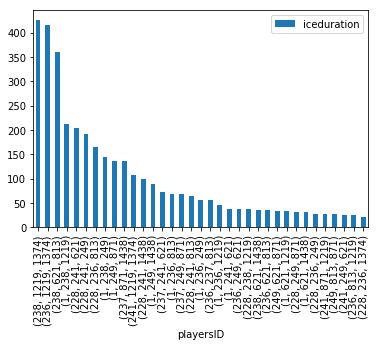

In [48]:
away_lines = get_away_lines(mtlott, accept_repeated=True) 

In [49]:
away_lines
# list(map(list, [np.sort(mtlott.player_classes.loc[list(a)]["class"].values) for a in away_lines]))
# [mtlott.recode_line(linedict, b) for b in [(238, 1219, 1374), (236, 1219, 1374), (238, 621, 813), (228, 241, 621)]]

# # Line translation table
# linedict  = HockeySS(repoPbP, repoPSt)
# linedict.make_line_dictionary()
# linedict  = linedict.line_dictionary


[[0, 2, 2], [0, 2, 2], [0, 0, 2], [0, 2, 2]]

In [52]:
# === Now we get the indices in the Q-values tables corresponding to lines

mtlott.pull_line_shifts(team='both', minduration=20)

# Line translation table
linedict  = HockeySS(repoPbP, repoPSt)
linedict.make_line_dictionary()
linedict  = linedict.line_dictionary

# Get lines and translate them 
playersCode  =   mtlott.encode_line_players()
linesCode    =   np.array( [[mtlott.recode_line(linedict, a) for a in b] for b in playersCode] )
# linedict

In [53]:
# Visualize the line codes for each shift (first digit is the code of the away team's line - state-space, 
# second digit is the code of the home team's line - action space)
linesCode

array([[ 9,  4],
       [ 6,  4],
       [ 2,  5],
       [ 9,  5],
       [ 6,  4],
       [ 6,  4],
       [ 2,  5],
       [ 2,  5],
       [ 9,  4],
       [ 6,  4],
       [ 2,  4],
       [ 6,  5],
       [-1,  5],
       [-1,  5],
       [-1,  5],
       [ 9,  4],
       [ 2,  5],
       [ 6,  4],
       [ 6,  4],
       [ 9,  4],
       [ 6,  4],
       [ 2,  5],
       [ 7,  4],
       [ 9,  5],
       [ 6,  5],
       [ 2,  4],
       [ 6,  5],
       [ 7,  4],
       [ 6,  5],
       [ 2,  5],
       [ 2,  5],
       [ 9,  4],
       [ 6,  5],
       [ 2,  4],
       [ 9,  4],
       [ 6,  5],
       [ 6,  5],
       [ 2,  5],
       [ 9, -1],
       [ 6,  4],
       [ 7,  5],
       [ 7,  4],
       [ 6,  5],
       [ 9,  5],
       [ 7,  5],
       [ 7,  5],
       [-1,  5],
       [-1,  5],
       [-1,  5],
       [-1,  5],
       [ 9,  4],
       [ 9, -1],
       [ 7, -1],
       [ 6,  5],
       [-1,  5],
       [-1,  5],
       [-1, -1],
       [-1, -1],
       [ 2,  5

In [54]:
# ==== Now we want to evaluate the value of the first shift for the (home team)

# Load the Qvalues table
Qvalues = pickle.load( open(path.join(repoCode, 'ReinforcementLearning/NHL/playbyplay/data/stable/RL_action_values.p'), 'rb') )['action_values']

# Visualize it dimensions (period x differential x away line's code x home line's code)
print('Q-table dimensions: ', Qvalues.shape)

# Get the Q-value for that specific line
iShift = 0 # First shift
plList = list(mtlott.player_classes.loc[mtlott.lineShifts['playersID'].iloc[iShift][0]]['firstlast'].values) + list(mtlott.player_classes.loc[mtlott.lineShifts['playersID'].iloc[iShift][1]]['firstlast'].values)
diff   = mtlott.recode_differential( mtlott.lineShifts.iloc[iShift].differential )
period = mtlott.recode_period( mtlott.lineShifts.iloc[iShift].period )
q_values = Qvalues[period,diff,linesCode[iShift,0], linesCode[iShift,1]]
print('[diff = %d, period = %d] First shift: \n\thome team: %s, %s, %s \n\taway team: %s, %s, %s \n\tQvalue: %.2f' %(diff, period, plList[0], plList[1], plList[2], plList[3], plList[4], plList[5], q_values) )
                                                                          


Q-table dimensions:  (3, 5, 10, 10)
[diff = 2, period = 0] First shift: 
	home team: DAVID DESHARNAIS, BRENDAN GALLAGHER, MAX PACIORETTY 
	away team: KYLE TURRIS, JAKOB SILFVERBERG, COLIN GREENING 
	Qvalue: 3.17


In [ ]:
# ###########################################################################################
# ###########################################################################################
# ###########################################################################################
class CategoryFetcher(object):

    def __init__(self, data_for_game):
        self.data_for_game = data_for_game

    def category_of_player(self, player_id: int) -> PlayerType:
        return get_class_of_player_by_id(self.data_for_game, player_id)


In [ ]:
cf = CategoryFetcher(data_for_game=mtlott)
cf.category_of_player(1374)

In [ ]:
class QValuesFetcher(object):

    def lines_to_index(home_line: List[PlayerType], away_line: List[PlayerType]) -> str:
        return ''.join(list(map(str, home_line + away_line)))

    def __init__(self):
        pass

    @abstractmethod
    def get(self, home_line: List[PlayerType], away_line: List[PlayerType]) -> float:
        raise NotImplementedError

class QValuesFetcherFromDict(QValuesFetcher):

    def __init__(self, a_dict: Dict):
        QValuesFetcher.__init__(self)
        self.dict = a_dict

    @classmethod
    def from_tuples(cls, q_value_tuples: List[Tuple[List[PlayerType], List[PlayerType], float]]):
        q_value_dict = {}
        for v in q_value_tuples:
            home_line, away_line, q_value = v
            for home_line_comb in list(set(itertools.permutations(home_line))):
                for away_line_comb in list(set(itertools.permutations(away_line))):
                    q_value_dict[QValuesFetcher.lines_to_index(home_line_comb, away_line_comb)] = q_value
        print("Q value dictionary has %d entries" % (len(q_value_dict)))
        return cls(a_dict=q_value_dict)

    def get(self, home_line: Set[PlayerType], away_line: Set[PlayerType]) -> float:
        from math import floor
        from random import uniform
        
        return uniform(1,30)
        # return self.dict[QValuesFetcher.lines_to_index(list(home_line), list(away_line))]
# ###########################################################################################
# ###########################################################################################
# ###########################################################################################



In [ ]:
q_value_tuples = [
    ([PlayerType.NEUTRAL, PlayerType.NEUTRAL, PlayerType.OFFENSIVE],
     [PlayerType.OFFENSIVE, PlayerType.DEFENSIVE, PlayerType.DEFENSIVE],
    25),
    ([PlayerType.NEUTRAL, PlayerType.NEUTRAL, PlayerType.OFFENSIVE],
     [PlayerType.NEUTRAL, PlayerType.NEUTRAL, PlayerType.NEUTRAL],
    12),
    ([PlayerType.NEUTRAL, PlayerType.NEUTRAL, PlayerType.NEUTRAL],
     [PlayerType.OFFENSIVE, PlayerType.DEFENSIVE, PlayerType.DEFENSIVE],
    20),
    ([PlayerType.NEUTRAL, PlayerType.NEUTRAL, PlayerType.NEUTRAL],
     [PlayerType.NEUTRAL, PlayerType.NEUTRAL, PlayerType.NEUTRAL],
    1),
]


In [ ]:
class LineRecommender(object):

    def __init__(self, player_category_fetcher: CategoryFetcher, q_values_fetcher: QValuesFetcher):
        self.player_category_fetcher=player_category_fetcher
        self.q_values_fetcher=q_values_fetcher


    def recommend_lines(
            self,
            home_team_players_ids: Set[int],
            away_team_lines: List[List[PlayerType]],
            comb_q_values: Callable[[List[float]], float]) -> List[List[int]]:
        """
        Builds optimal lines for home team.
        Args:
            home_team_players_ids: a list of id's for home team.
            away_team_lines: 4 lines of away team. Each line is composed of 3 players, represented by their class (0 = defensive, 2 = offensive, 1 = neither)
            q_values: a function that given 2 lines (represented by CLASSES of players) returns the q-value of the home team line.
            comb_q_values: how to combine the q-values in order to obtain a "fitness" for a formation (larger is better).
        Returns:

        """
        import datetime
        assert len(home_team_players_ids) == len(set(home_team_players_ids)), "There are repeated ids in the home team"
        assert len(away_team_lines) == 4, "I need a formation (ie, 4 lines) for away team"

        away_line_1, away_line_2, away_line_3, away_line_4 = away_team_lines
        best_fitness = None
        best_formation = None
        how_many_first_lines_tried = 0
        #
        entry_timestamp = datetime.datetime.now().timestamp()
        for home_line_1_ids in itertools.combinations(home_team_players_ids, 3):
            best_formation_found = False
            for home_line_2_ids in itertools.combinations(home_team_players_ids -  set(home_line_1_ids), 3):
                for home_line_3_ids in itertools.combinations(
                                        home_team_players_ids - set(home_line_1_ids) - set(home_line_2_ids), 3):
                    for home_line_4_ids in itertools.combinations(
                                        home_team_players_ids - set(home_line_1_ids) - set(home_line_2_ids) - set(home_line_3_ids), 3):
                        home_formation = [home_line_1_ids, home_line_2_ids, home_line_3_ids, home_line_4_ids]

                        # print(home_formation)
                        # get lines with CATEGORY of players
                        home_line_1 = list(map(self.player_category_fetcher.category_of_player, home_line_1_ids))
                        home_line_2 = list(map(self.player_category_fetcher.category_of_player, home_line_2_ids))
                        home_line_3 = list(map(self.player_category_fetcher.category_of_player, home_line_3_ids))
                        home_line_4 = list(map(self.player_category_fetcher.category_of_player, home_line_4_ids))
                        # ok, then:
                        qs = [self.q_values_fetcher.get(home_line_1, away_line_1),
                              self.q_values_fetcher.get(home_line_2, away_line_2),
                              self.q_values_fetcher.get(home_line_3, away_line_3),
                              self.q_values_fetcher.get(home_line_4, away_line_4)]
                        fitness = comb_q_values(qs)
                        # print(qs)
                        if (best_fitness is None) or (fitness > best_fitness):
                            best_fitness = fitness
                            best_formation = home_formation
                            best_formation_found = True
                            print("Best fitness: %.2f by formation %s" % (best_fitness, best_formation))


            how_many_first_lines_tried += 1
            if best_formation_found:
                time_it_took = datetime.datetime.now().timestamp() - entry_timestamp
                time_per_cycle = time_it_took / how_many_first_lines_tried
                print("=======> Took %.2f secs. to look at %d first-lines; I think we have around %.2f secs. to go" % (
                time_it_took, how_many_first_lines_tried, (220 - how_many_first_lines_tried) * time_per_cycle))

        print("ALL DONE!!!!!!")
        print("================================")
        print("Best fitness: %.2f by formation \n%s, to play against \n%s" % (best_fitness, best_formation, away_team_lines))
        print("================================")
        return best_formation

    def recommend_lines_maximize_average(
            self,
            home_team_players_ids: Set[int],
            away_team_lines: List[List[PlayerType]]) -> List[List[int]]:
        return self.recommend_lines(home_team_players_ids, away_team_lines, comb_q_values=(lambda a_list: sum(a_list) / len(a_list)))

    def recommend_lines_maximize_max(
            self,
            home_team_players_ids: Set[int],
            away_team_lines: List[List[PlayerType]]) -> List[List[int]]:
        return self.recommend_lines(home_team_players_ids, away_team_lines, comb_q_values=(lambda a_list: max(a_list)))
# ###########################################################################################
# ###########################################################################################
# ###########################################################################################


# ############################################################
# PUT ALL THE FOLLOWING INTO TESTING



In [ ]:
line_rec = LineRecommender(
    player_category_fetcher=CategoryFetcher(data_for_game=mtlott),
    q_values_fetcher=QValuesFetcherFromDict.from_tuples(q_value_tuples))



In [ ]:
home_lines_rec = line_rec.recommend_lines_maximize_average(
                                home_team_players_ids=get_MTL_players(players_classes),
                                away_team_lines = away_lines)
print(home_lines_rec)
